#### Isobaric nitrogen

* This notebook sets up the isobaric evaporation of liquid nitrogen in a Linde $80m^3$ tank to compare evaporation rates with the same case but with the tank closed
* Coolprop will be called to retrieve the cryogen thermophysical properties. Hence, the cryogen will be specificied in the notebook

## Desired input and output
* Tank characteristics: .CSV file with tank geometrical properties
* Cryogen: .CSV file with the cryogen ID consistent with coolprop
* Popular cryogens: hydrogen, methane, nitrogen, oxygen.


In [1]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

## Module imports
# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen
# from cryoevap.cryogens import Cryogen

#### Use example

Analyse BOG rates of liquid hydrogen in a retrofitted LNG storage tank,and compare it to methane BOG rates. In this case, it is assumed that all the heat ingress is transferred to the vapour ($\eta_w = 0$).

In [2]:
# Retrofitted LNG tank properties
Q_roof = 0 # Roof heat ingress / W
d_i = 2.706 # Internal diameter / m
d_o = 3   # External diameter / m
T_air = 298.15 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 7.237e-3 # W/m2/K
U_V = 7.237e-3 # W/m2/K

# Specify heat transfer rate at the bottom to prevent ground heating
Q_b = 0 # W, no heat ingress from the tank bottom 

# Vertically orientated cylindrical tank volume
V_tank = 80.36 #m^3

# Initial liquid filling / Dimensionless
LF = 0.97 

# Specify tank operating pressure
P = 100000 # Pa

# Initialize tank
large_tank = Tank(d_i, d_o, V_tank, LF)
large_tank.set_HeatTransProps(U_L, U_V, T_air, Q_roof, Q_b, eta_w = 0.91)

In [3]:
# Initialise cryogen
nitrogen = Cryogen(name = "nitrogen")
nitrogen.set_coolprops(P)
large_tank.cryogen = nitrogen
print("The evaporation rate of " + nitrogen.name + " is %.1f kg/h" % (large_tank.b_l_dot * 3600))
print("Equivalent to %.1f g/s" % (large_tank.b_l_dot * 1000))

The evaporation rate of nitrogen is 3.7 kg/h
Equivalent to 1.0 g/s


Liquid nitrogen properties for Linde tank calculations

In [4]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + nitrogen.name + " is %.1e kg/h" % (large_tank.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % large_tank.tau)

# Minimum number of hours to achieve steady state 
tau_h = (np.floor(large_tank.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h )

# Calculate boil-off rate
BOR = (large_tank.b_l_dot * 24 * 3600) / (large_tank.V * large_tank.LF * large_tank.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR * 100))

The initial evaporation rate of nitrogen is 3.7e+00 kg/h
Transient period = 10721.031 s 
Simulation time: 3 h
BOR = 0.141 %


#### Simulation setup and execution

In [5]:
# Define vertical spacing
dz = 0.005

# Calculate number of nodes
n_z = 1 + int(np.round(large_tank.l_V/dz, 0))

# Define dimensionless computational grid
large_tank.z_grid = np.linspace(0, 1, n_z)

# Insulated roof
large_tank.U_roof = 0

# Define evaporation time as twice as the transient period
evap_time = 3600 *tau_h * 2

# Time step to record data, relevant for plotting integrated quantities
# such as the vapour to liquid heat transfer rate, Q_VL
large_tank.time_interval = 60

# Time step to plot each vapour temperature profile
large_tank.plot_interval = evap_time/6

# Simulate the evaporation
large_tank.evaporate(evap_time)

#### Vapour temperature

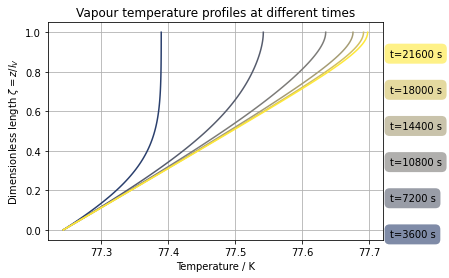

In [6]:
# Visualise the plot
large_tank.plot_tv()

Plot vapour temperature profile

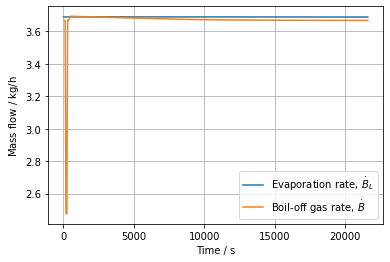

In [7]:
large_tank.plot_BOG()

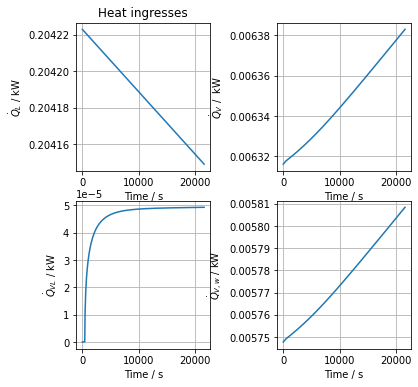

In [8]:
large_tank.plot_Q()

In [9]:
# Calculate evaporated mass
BOG = np.trapz(large_tank.data['BOG'], large_tank.data['Time'])
# BOG = (large_tank.data['V_L'][0] -large_tank.data['V_L'][-1]) * nitrogen.rho_L
print("BOG = %.3f kg" % BOG)

BOG = 22.005 kg


Text(0, 0.5, '$ B_L / kg/h$')

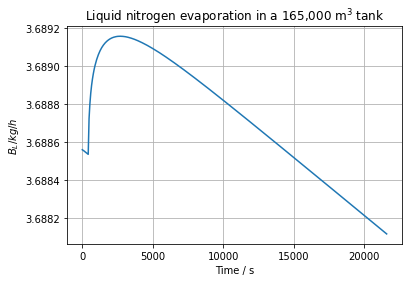

In [10]:
# Extract evaporation rate and convert to kg/h
B_L = large_tank.evap_rate() * 3600

# Visualise evaporation rate
plt.plot(large_tank.sol.t, B_L) 
plt.grid()
plt.title("Liquid nitrogen evaporation in a 165,000 m$^3$ tank")
plt.xlabel('Time / s')
plt.ylabel('$ B_L / kg/h$')

In [11]:
large_tank.V

80.36